An introduction to SunPy and Solar Sources<img src="https://raw.githubusercontent.com/sunpy/sunpy.org/main/_static/img/sunpy_icon.svg" alt="logo" width="100" align="right"/>
====================
The [`sunpy`](https://sunpy.org
) Python package is a community-developed, free, and open-source solar data analysis environment for Python!  

sunpy provides the core functionality and tools to analyze solar data with Python!

In this notebook we'll go through an introduction of how we can use sunpy and other scientific packages such as astropy etc to perform solar data analysis. We'll focus on how to search and query data, download data, load data into different containers, and how to plot and manipulate data.

The notebook is divided into several sections:

1. An introduction to astropy units
2. Coordinates in SunPy
3. How to search for and download solar data such as timeseries and images of the Sun from different instruments and different wavelengths
4. Data containers available within sunpy:
    - Map
    - TimeSeries
5. Plotting and manipulating the data 

6. Exercises - Do some of your own analysis!

## Import the packages we'll use in this notebook

In [1]:
from sunpy.net import Fido, attrs as a 
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord
import sunpy.timeseries
import sunpy.map
from sunpy.time import parse_time

from astropy import units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np 


# 1. Astropy Units

[`astropy.units`](https://docs.astropy.org/en/stable/units/) provides a means to deal with and handle numbers/arrays etc that have an associated physical quantity (e.g. km, seconds, Kelvin). Throughout SunPy, any physical input or outputs is an [`astropy.Quantity`](https://docs.astropy.org/en/stable/units/quantity.html#quantity). Lets look at how we can create and convert between astropy units. Above we have imported `astropy.units` as `u`

In [2]:
distance_in_km = 10*u.km

In [3]:
distance_in_km

<Quantity 10. km>

In [4]:
distance_in_km.value

10.0

In [5]:
distance_in_km.unit

Unit("km")

In [6]:
distance_in_km.cgs

<Quantity 1000000. cm>

We can convert between units e.g.

In [7]:
distance_in_km.to(u.Mm)

<Quantity 0.01 Mm>

In [8]:
distance_in_km.to(u.parsec)

<Quantity 3.24077929e-13 pc>

However you can only convert between physical units that make sense for example:

In [9]:
distance_in_km.to(u.second)

UnitConversionError: 'km' (length) and 's' (time) are not convertible

In [11]:
time_in_sec = 60*u.s

In [12]:
(distance_in_km/time_in_sec).unit

Unit("km / s")

# 2. Coordinates

SunPy uses [`astropy.coordinates`](https://docs.astropy.org/en/stable/coordinates/index.html) to represent points in physical space. This applies to both points in 3D space and projected coordinates in images.

The `sunpy.coordinates` sub-package contains:

* A robust framework for working with solar-physics coordinate systems
* Functions to obtain the locations of solar-system bodies (`sunpy.coordinates.ephemeris`)
* Functions to calculate Sun-specific coordinate information (`sunpy.coordinates.sun`)




We deal with coordinates by using astropy's [`SkyCoord`](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord) class. 


A **coordinate** combines position data with a coordinate frame, and a SkyCoord object is created by passing in positions with specified units and a coordinate frame. Above in the imports cell we've imported [`sunpy.coordinates.frames`](https://docs.sunpy.org/en/stable/code_ref/coordinates/index.html#supported-coordinate-systems) which allow us to use solar physics specific frames such as Helioprojective, Heliographic Stonyhurst, Heliocentric etc. 

Lets create a point on the Sun in lat and long in the Heliographic Stonyhurst coordinate system

In [13]:
# longitude, latitude
hgs_coord = SkyCoord(10*u.deg, 20*u.deg, obstime="2017-08-01", frame=frames.HeliographicStonyhurst)  
hgs_coord

<SkyCoord (HeliographicStonyhurst: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km): (lon, lat) in deg
    (10., 20.)>

In [14]:
print(f"""Longitude: {hgs_coord.lon}
Latitude: {hgs_coord.lat}
Distance from Sun center: {hgs_coord.radius}""")

Longitude: 10.0 deg
Latitude: 20.0 deg
Distance from Sun center: 1.0


In [15]:
hgs_coord_xyz = SkyCoord(hgs_coord, representation_type='cartesian')
hgs_coord_xyz

<SkyCoord (HeliographicStonyhurst: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km): (x, y, z) [dimensionless]
    (0.92541658, 0.16317591, 0.34202014)>

We can then transform this coordinate to the any defined coordinate frame defined in astropy or sunpy. Lets transform it to the Helioprojective frame (which is observer-based)

In [16]:
hgs_coord.transform_to(frames.Helioprojective(observer="earth"))

<SkyCoord (Helioprojective: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (154.89224085, 234.48634082, 1.51172864e+08)>

We can also convert this to other coordinate systems outside the solar-specific ones - for examples ICRS

In [17]:
hgs_coord.transform_to("icrs")

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, km)
    (16.45495249, 16.01388665, 980067.1475033)>

## 2.1 An important note about observer based frames

Some coordinate frames are defined based on the position of the observer e.g. the Helioprojective and Heliocentric frames. Hence it's important to think about this - particularly when transforming points between coordinate systems. 
This is shown above when transforming to Helioprojective we needed to pass an `observer` keyword. Similarly, its important that the `obstime` is given also!

For example, lets define a point on the Sun in Helioprojective and see what that equivalent point would be from another observer - say Mars!

In [18]:
obstime = "2021-04-11 00:00"

In [19]:
hpc_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, observer="earth", 
                     obstime=obstime, frame=frames.Helioprojective)
hpc_coord

<SkyCoord (Helioprojective: obstime=2021-04-11T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec
    (0., 0.)>

In [20]:
print(hpc_coord.Tx, hpc_coord.Ty)

0arcsec 0arcsec


In [21]:
mars_hpc_coord = hpc_coord.transform_to(frames.Helioprojective(observer="mars"))
mars_hpc_coord

<SkyCoord (Helioprojective: obstime=2021-04-11T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'mars'>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (586.35256015, -58.93380646, 1.62408482)>

In [22]:
print(mars_hpc_coord.Tx, mars_hpc_coord.Ty)

586.353arcsec -58.9338arcsec


# 3. Searching and Downloading Data



## 3.1 Overview of sunpy's Fido Unified Downloader


* [`Fido`](https://docs.sunpy.org/en/stable/guide/acquiring_data/fido.html#fido-guide) is sunpy's interface for searching and downloading solar physics data.

* It offers a unified interface for searching and fetching data irrespective of the underlying client or webservice from where the data is obtained.

* Offers a way to search and accesses multiple instruments and all available data providers in a single query.

* It supplies a single, easy, consistent and *extendable* way to get most forms of solar physics data the community need 

Fido offers access to data available through:

 * **VSO**
 * **JSOC** (through `drms`)
 * **Individual data providers** from web accessible sources (http, ftp, etc)
 * **HEK**
 * **HELIO**

As described here Fido provides access to many sources of data through different `clients`, these clients can be defined inside sunpy or in other packages. Lets print the current list of available clients within sunpy.

In [23]:
Fido

Client,Description
EVEClient,Provides access to Level 0C Extreme ultraviolet Variability Experiment (EVE) data.
GBMClient,Provides access to data from the Gamma-Ray Burst Monitor (GBM) instrument on board the Fermi satellite.
XRSClient,Provides access to the GOES XRS fits files archive.
SUVIClient,Provides access to data from the GOES Solar Ultraviolet Imager (SUVI).
GONGClient,Provides access to the Magnetogram products of NSO-GONG synoptic Maps.
...,...
NoRHClient,Provides access to the Nobeyama RadioHeliograph (NoRH) averaged correlation time series data.
RHESSIClient,Provides access to the RHESSI observing summary time series data.
HEKClient,Provides access to the Heliophysics Event Knowledgebase (HEK).
HECClient,Provides access to the HELIO webservices.


### Using attributes to search for data with Fido

Sunpy uses specified *attributes* to search for data using Fido. The range of these attributes is located in the `attrs` submodule. These `attr` parameters can be combined together to construct data search queries, such as searching over a certain time period, for data from a certain instrument with a certain wavelength etc.

Different clients and provides will have client-specific attributes, but the core attributes are:

* `a.Time`
* `a.Instrument`
* `a.Wavelength`


Lets look at how these attributes work in more detail.

First we can look at a.Time, which is used to specify the timerange of a query.

In [24]:
a.Time("2021-05-23 02:00", "2021-05-23 04:00")

<sunpy.net.attrs.Time(2021-05-23 02:00:00.000, 2021-05-23 04:00:00.000)>

We can inspect the instrument attribute to see what instrument `attrs` are currently supported through sunpy. Here we can see the instrument name (i.e. the name to be passed to the `a.Instrument` attribute, the client from which the data is available to access, and the full name of the instrument.

In [25]:
a.Instrument

Attribute Name,Client,Full Name,Description
aia,VSO,AIA,Atmospheric Imaging Assembly
bbi,VSO,BBI,None
bcs,VSO,BCS,Bragg Crystal Spectrometer
be_continuum,VSO,BE-Continuum,INAF-OACT Barra Equatoriale Continuum Instrument
be_halpha,VSO,BE-Halpha,INAF-OACT Barra Equatoriale Hα Instrument
bic_hifi,VSO,BIC-HIFI,None
bigbear,VSO,Big Bear,"Big Bear Solar Observatory, California TON and GONG+ sites"
caii,VSO,CAII,Kanzelhöhe Ca II k Instrument
cds,VSO,CDS,Coronal Diagnostic Spectrometer
celias,VSO,CELIAS,"Charge, Element, and Isotope Analysis System"


Sunpy also now provides tab completion to auto-fill the attribute name

In [26]:
a.Instrument.eit

<sunpy.net.attrs.Instrument(EIT: Extreme ultraviolet Imaging Telescope) object at 0x13bf87c10>

To search for certain wavelengths, we need to specify the input as an `astropy Quantity` which is a the combination of a value and an associated unit. This is something is universal in the sunpy stack - that every physical input/output is a `Quantity`.

In [27]:
a.Wavelength(17.1*u.angstrom)

<sunpy.net.attrs.Wavelength(17.1, 17.1, 'Angstrom')>

## 3.2 Constructing a search query
 ### A simple query

Lets create a simple query to search for data from AIA over a particular time period

In [28]:
result = Fido.search(a.Time("2021-05-23 11:00", "2021-05-23 11:20"), 
                     a.Instrument("AIA"))

In [30]:
result

Now lets make our query a bit more specific, say, say we only want one wavelength band from AIA. This can be achieved by specifying the Wavelength attribute within the search. The Wavelength attribute is passed as an astropy Quantity:

In [31]:
result = Fido.search(a.Time("2021-05-23 11:00", "2021-05-23 11:20"), 
                     a.Instrument("AIA"), 
                     a.Wavelength(171*u.angstrom))

In [ ]:
result

We can further specify this query by choosing the cadence (time-sampling) of the data we want to search for and download. This can be achieved by using the Sample attribute. Similar to the Wavelength attributes, this needs to be an astropy Quantity. Lets further specify the search above to only search for data with a cadence of 2 minutes.

In [32]:
result = Fido.search(a.Time("2021-05-23 11:00", "2021-05-23 11:20"), 
                     a.Instrument("AIA"), 
                     a.Wavelength(171*u.angstrom),
                     a.Sample(2*u.min))

In [33]:
len(result[0])

10

## 3.3 Downloading the data

Now we can show how data that is queried above can be downloaded. Once the data you have searched for (and filtered etc) is constructed into a query using `Fido.search`, you can then easily download them using `Fido.fetch`.

The data is downloaded via asynchronous and parallel download streams (via parfive), and also allows for failed data downloads to be recognized so that files can be re-requested if not downloaded.

Lets now look at how a `UnifiedResponse` from a `Fido.search` can be passed to `Fido.fetch` to download the data

In [34]:
files = Fido.fetch(result)

Files Downloaded:   0%|          | 0/10 [00:00<?, ?file/s]

These files are downloaded to a local location set in the sunpy.config.file, which by default is ~/sunpy/data/. Fido.fetch returns a parfile.Results object which gives the path to where the files are downloaded to

In [35]:
print(files[0])

/Users/laurahayes/sunpy/data/aia_lev1_171a_2021_05_23t11_18_09_35z_image_lev1.fits


You can also define what directory you want the files to be saved to by passing the directory path to the path keyword in Fido.fetch. For example, I want to download these files to a local directory `/Users/laurahayes/SWW_tutorial/`

In [36]:
Fido.fetch(result[0, 0], path="/Users/laurahayes/SWW_tutorial/")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['/Users/laurahayes/SWW_tutorial/aia_lev1_171a_2021_05_23t11_00_09_35z_image_lev1.fits']

## 3.4 More complex queries

In addition to making a query to one client for one instrument, Fido allows the flexibility to search for data from multiple instruments, wavelengths, times etc, even when the data is being obtained through different clients.

This query can be constructed by using the pipe | operator, which joins queries together just like the OR operator.

Lets now make a query that searches for both GOES/XRS and AIA data over a particular time period

In [37]:
result = Fido.search(a.Time("2011-06-07 06:00", "2011-06-07 12:00"), 
                     a.Instrument.xrs  | (a.Instrument.aia & a.Wavelength(171*u.angstrom)))

/Users/laurahayes/opt/miniconda3/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


In [38]:
len(result)

2

In [39]:
result

<sunpy.net.fido_factory.UnifiedResponse object at 0x13ce0f820>
Results from 2 Providers:

1 Results from the XRSClient:
       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2011-06-07 00:00:00.000 2011-06-07 23:59:59.999        XRS ...   GOES     NOAA

1801 Results from the VSOClient:
       Start Time       ...
                        ...
----------------------- ...
2011-06-07 06:00:00.000 ...
2011-06-07 06:00:12.000 ...
2011-06-07 06:00:24.000 ...
2011-06-07 06:00:36.000 ...
2011-06-07 06:00:48.000 ...
2011-06-07 06:01:00.000 ...
2011-06-07 06:01:12.000 ...
2011-06-07 06:01:24.000 ...
2011-06-07 06:01:36.000 ...
2011-06-07 06:01:48.000 ...
                    ... ...
2011-06-07 11:58:12.000 ...
2011-06-07 11:58:24.000 ...
2011-06-07 11:58:36.000 ...
2011-06-07 11:58:48.000 ...
2011-06-07 11:59:00.000 ...
2011-06-07 11:59:12.000 ...
2011-06-07 11:59:24.000 ...
2011-06-07 11:59:36.000 ...
2011-06-07 11:59:48.000 ...
2011-06-07 12:00:00.000 ...
Length = 1801 rows

In [40]:
result[0]

Start Time,End Time,Instrument,SatelliteNumber,Physobs,Source,Provider
object,object,str3,int64,str10,str4,str4
2011-06-07 00:00:00.000,2011-06-07 23:59:59.999,XRS,15,irradiance,GOES,NOAA


In [41]:
result[1]

Start Time,End Time,Source,Instrument,Wavelength [2],Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Info
,,,,Angstrom,,,,,,,Mibyte,
object,object,str3,str3,float64,str4,str9,str6,str4,str4,str8,float64,str57
2011-06-07 06:00:00.000,2011-06-07 06:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"
2011-06-07 06:00:12.000,2011-06-07 06:00:13.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"
2011-06-07 06:00:24.000,2011-06-07 06:00:25.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"
2011-06-07 06:00:36.000,2011-06-07 06:00:37.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"
2011-06-07 06:00:48.000,2011-06-07 06:00:49.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"
2011-06-07 06:01:00.000,2011-06-07 06:01:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"
2011-06-07 06:01:12.000,2011-06-07 06:01:13.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"
2011-06-07 06:01:24.000,2011-06-07 06:01:25.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"


In [42]:
result.all_colnames

['End Time',
 'Instrument',
 'Physobs',
 'Provider',
 'SatelliteNumber',
 'Source',
 'Start Time',
 'url']

Lets download the GOES XRS data first

In [43]:
Fido.fetch(result[0, 0], path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['sci_gxrs-l2-irrad_g15_d20110607_v0-0-0.nc']

Now lets say we only want to download one AIA file at a particular time, we can also search the table for certain conditions. Lets say we just want the file that closest to 2011-06-07 06:00. 

In [44]:
(np.abs(result[1]["Start Time"] - parse_time("2011-06-07 06:33"))).argmin()

165

In [45]:
Fido.fetch(result[1, 165], path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['aia_lev1_171a_2011_06_07t06_33_02_77z_image_lev1.fits']

4 . Data Containers
=============

Now we have seen how we can search for and download data - lets now look at how we can read this data in.

SunPy provides core data type classes that are designed to provide a consistent interface across data types (timeseries and images) as well as data sources from numerous instruments and observations. They handle all of the manipulation necessary to read data in from mission-specific files. The two main datatypes in SunPy are the `TimeSeries` and `Map` classes.

## 4.1 TimeSeries

The structure of a [`TimeSeries`](https://docs.sunpy.org/en/stable/guide/data_types/timeseries.html) consists of times and measurements and the underlying structure is that of a `pandas.DataFrame`. 

SunPy TimeSeries supports time-series data from a wide range of solar-focused instruments. `TimeSeries` can either be created manually or from source files that are currently supported. If a supported file is passed to `TimeSeries` it will automatically detect its source and its instrument-specific meta data will be loaded. 

Lets create a timeseries from out sample data which is X-ray flux from the GOES X-ray Sensor Data. This data file was downloaded locally in the steps above! 

In [46]:
xrs = sunpy.timeseries.TimeSeries('sci_gxrs-l2-irrad_g15_d20110607_v0-0-0.nc')

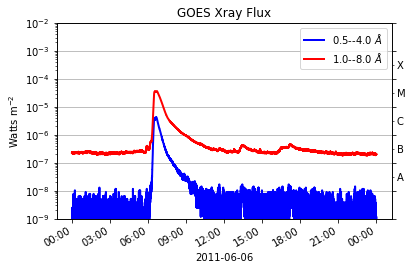

In [47]:
xrs.peek()

### Inspect the TimeSeries

Lets now inspect the TimeSeries and get at the data. A timeseries holds data as well as meta data and unit data.

In [48]:
xrs.units

OrderedDict([('xrsa', Unit("W / m2")), ('xrsb', Unit("W / m2"))])

In [49]:
xrs.meta

|-------------------------------------------------------------------------------------------------|
|TimeRange                  | Columns         | Meta                                              |
|-------------------------------------------------------------------------------------------------|
|2011-06-06T23:59:34.985082 | xrsa            | conventions: b'ACDD-1.3, Spase v2.2.6'            |
|            to             | xrsb            | title: b'GOES 1-15 L2 XRS high-resolution Irradian|
|2011-06-07T23:59:32.655082 |                 | id: b' '                                          |
|                           |                 | summary: b'The X-ray flux product consists of repr|
|                           |                 | keywords: b'NumericalData.MeasurementType.Irradian|
|                           |                 | keywords_vocabulary: b'SPASE: Space Physics Archiv|
|                           |                 | naming_authority: b'gov.nesdis.noaa'              |


In [50]:
xrs.data

,xrsa,xrsb
2011-06-06 23:59:34.985082,-1.437680e-09,2.313504e-07
2011-06-06 23:59:37.035082,-4.070067e-09,2.351139e-07
2011-06-06 23:59:39.081082,-1.437680e-09,2.275868e-07
2011-06-06 23:59:41.128082,-4.070067e-09,2.351139e-07
2011-06-06 23:59:43.178082,-2.753874e-09,2.275868e-07
...,...,...
2011-06-07 23:59:24.465082,-1.437680e-09,2.012418e-07
2011-06-07 23:59:26.515082,1.194707e-09,1.974782e-07
2011-06-07 23:59:28.561082,-2.753874e-09,2.012418e-07
2011-06-07 23:59:30.608082,-2.753874e-09,1.974782e-07


In [51]:
xrs.columns

['xrsa', 'xrsb']

In [52]:
xrs.quantity("xrsa")

<Quantity [-1.4376802e-09, -4.0700670e-09, -1.4376802e-09, ...,
           -2.7538736e-09, -2.7538736e-09, -1.2148683e-10] W / m2>

it can also be converted to a pandas.DataFrame if you fancy

In [53]:
xrs.to_dataframe()

,xrsa,xrsb
2011-06-06 23:59:34.985082,-1.437680e-09,2.313504e-07
2011-06-06 23:59:37.035082,-4.070067e-09,2.351139e-07
2011-06-06 23:59:39.081082,-1.437680e-09,2.275868e-07
2011-06-06 23:59:41.128082,-4.070067e-09,2.351139e-07
2011-06-06 23:59:43.178082,-2.753874e-09,2.275868e-07
...,...,...
2011-06-07 23:59:24.465082,-1.437680e-09,2.012418e-07
2011-06-07 23:59:26.515082,1.194707e-09,1.974782e-07
2011-06-07 23:59:28.561082,-2.753874e-09,2.012418e-07
2011-06-07 23:59:30.608082,-2.753874e-09,1.974782e-07


It also has several methods to manipulate the data such removing certain values as well as truncating.
Lets truncate the data over the time-range of the flare

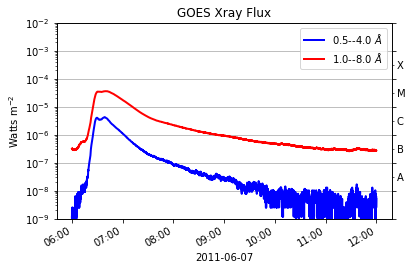

In [54]:
xrs.truncate("2011-06-07 06:00", "2011-06-07 12:00").peek()

In [55]:
xrs_flare = xrs.truncate("2011-06-07 06:00", "2011-06-07 09:00")
xrs_flare.meta

|-------------------------------------------------------------------------------------------------|
|TimeRange                  | Columns         | Meta                                              |
|-------------------------------------------------------------------------------------------------|
|2011-06-07T06:00:01.585082 | xrsa            | conventions: b'ACDD-1.3, Spase v2.2.6'            |
|            to             | xrsb            | title: b'GOES 1-15 L2 XRS high-resolution Irradian|
|2011-06-07T08:59:58.451082 |                 | id: b' '                                          |
|                           |                 | summary: b'The X-ray flux product consists of repr|
|                           |                 | keywords: b'NumericalData.MeasurementType.Irradian|
|                           |                 | keywords_vocabulary: b'SPASE: Space Physics Archiv|
|                           |                 | naming_authority: b'gov.nesdis.noaa'              |


In [56]:
xrs.to_dataframe()["xrsa"][0] = 100

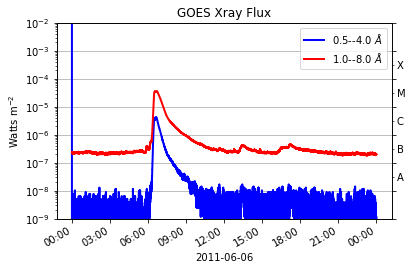

In [57]:
xrs.peek()

## 4.2 Map


The sunpy [`Map`](https://docs.sunpy.org/en/stable/guide/data_types/maps.html) class provides the data type structure to store 2-dimensional data associated with a coordinate system.  This allows users to store and manipulate images of the Sun and the heliosphere

Maps from all instruments are created using the `sunpy.map.Map` 'factory'. This class takes a wide variety of map-like inputs, for one or more maps and returns you one or many maps. All maps, irrespective of the instrument, behave the same and expose the same functions and properties, however, depending on the instrument different metadata might be read or corrections made.

In [58]:
aia_map = sunpy.map.Map('aia_lev1_171a_2011_06_07t06_33_02_77z_image_lev1.fits')

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2011-06-07 06:33:02
Exposure Time,0.234256 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.599489 0.599489] arcsec / pix
Reference Pixel,[2049.459961 2049.030029] pix

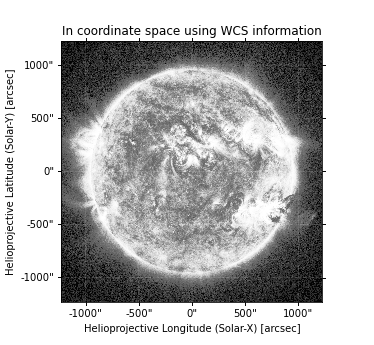
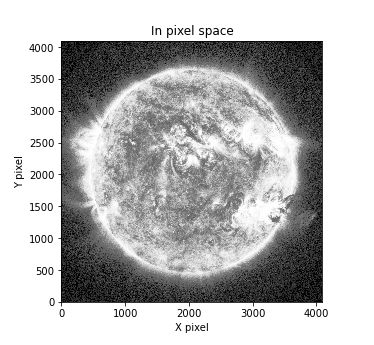
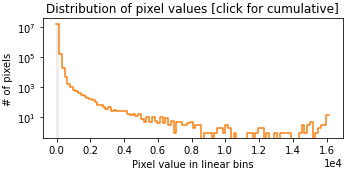
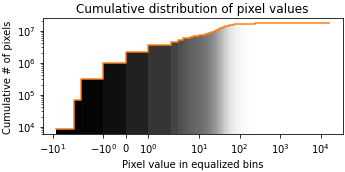

In [59]:
aia_map

Map provides customized loaders for a number of different instruments, however, if the data file follows the FITS data standards for coordinate information etc then map should be able to read it by default.

Map has a set of attributes which give access to common metadata, which provides a consistent interface for different instruments, lets look at some of these here

In [60]:
aia_map.unit

Unit("ct")

In [61]:
# observer location coordinate - this is the coordinate in space of SDO/AIA
aia_map.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2011-06-07T06:33:02.770, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00406308, 0.04787238, 1.51846026e+11)>

In [62]:
# coordinate frame of observation - helioprojective (HPC)
aia_map.coordinate_frame

<Helioprojective Frame (obstime=2011-06-07T06:33:02.770, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.770, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00406308, 0.04787238, 1.51846026e+11)>)>

In [63]:
# The wavelength of the observation
aia_map.wavelength

<Quantity 171. Angstrom>

In [64]:
# The radius of the sun in angular and distance units
aia_map.rsun_obs

<Quantity 945.436711 arcsec>

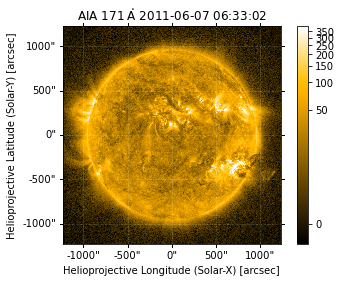

In [65]:
aia_map.plot(clip_interval=(1, 99.9)*u.percent)
plt.colorbar()

## Inspecting and Manipulating the Data

The data in a SunPy Map object is accessible through the data attribute. The data is implemented as a NumPy ndarray, so for example, to get the 0th element in the array.

One important fact to remember is that the first index is for the y direction while the second index is for the x direction! 

In [66]:
aia_map.data

array([[ 0, -1,  2, ..., -1,  0, -1],
       [-1,  1,  1, ...,  0,  0,  0],
       [ 0,  0,  1, ..., -2,  1, -2],
       ...,
       [ 0, -1, -1, ...,  1,  3,  0],
       [ 0,  2, -2, ...,  0,  0,  0],
       [ 1,  0, -1, ..., -1, -2,  0]], dtype=int16)

In [67]:
aia_map.data.shape

(4096, 4096)

In [68]:
aia_map.data[0][0]

0

In [69]:
print("Mean:", aia_map.mean(), "Max:", aia_map.max(), "Min:", aia_map.min(),  "Std:", aia_map.std())

Mean: 27.2545285820961 Max: 16137 Min: -8 Std: 55.9049207266178


We can convert between the world coordinates (arcsec) to pixel coordinates using the `world_to_pixel` method on map which takes a SkyCoord and then returns the pixel coordinate. Similarly we can find the world coordinate to the pixel (or array) index. This is done with the `pixel_to_world` method. Lets first look at finding the array (pixel) index for the center of the Sun (0, 0) arcsec:

In [73]:
aia_map.world_to_pixel(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=aia_map.coordinate_frame))

PixelPair(x=<Quantity 2049.459961 pix>, y=<Quantity 2049.030029 pix>)

Now lets try find where the max value of the map is and the coordinate of it in arcsec:

In [75]:
max_pixel_pos = np.argwhere(aia_map.data==aia_map.max())[0]
max_pixel_pos

array([1453, 3242])

In [76]:
max_coord = aia_map.pixel_to_world(max_pixel_pos[1]*u.pixel, max_pixel_pos[0]*u.pixel)

## Plotting a Map

SunPy map uses the [`astropy.visualization.wcsaxes`](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html#module-astropy.visualization.wcsaxes) module to represent world coordinates. 

Using WCSAxes is very powerful but has important concepts to think about:

 * **`world`** coordinates refer to the coordinates of the coordinate system - i.e. arcsec, degrees!
 * **`pixel`** coordinates refer to the array index of the data! i.e. data[10] etc
 
 
When plotting on WCSAxes it will by default plot in pixel coordinates, you can override this behavior and plot in `world` coordinates by getting the transformation from the axes with `ax.get_transform('world')`. We will use some of these examples below. Its also important to note that when using the `world` coordinates these have to be in **degrees** so make sure to convert arcsec's to degrees.

In [77]:
aia_map.data.shape

(4096, 4096)

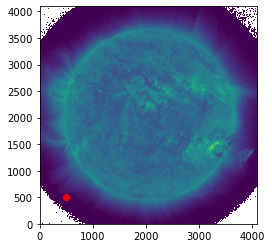

In [78]:
plt.imshow(aia_map.data, origin="lower", norm=colors.LogNorm(), cmap="viridis")
plt.plot(500, 500, marker='o', color="r")

Now lets look how to properly do this with a map and WCSAxes

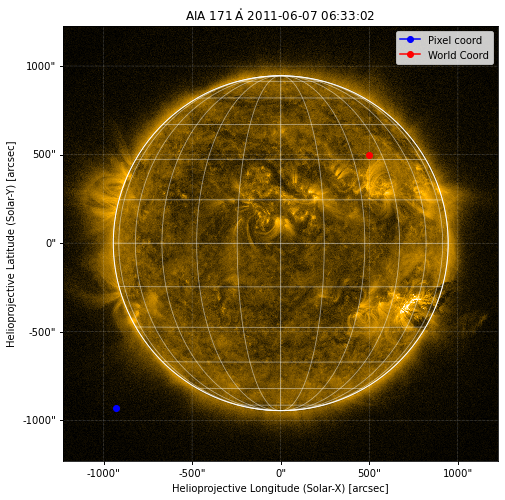

In [79]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=aia_map)  

# plot the map
aia_map.plot(clip_interval=[0.5, 99.99]*u.percent)
aia_map.draw_limb()
aia_map.draw_grid()

# plot in pixel coordinates
ax.plot(500, 500, marker='o', color="b",  label="Pixel coord")

# plot in world coordinates
ax.plot((500*u.arcsec).to(u.deg), (500*u.arcsec).to(u.deg),
        transform=ax.get_transform('world'), 
        marker='o',color="r", label="World Coord")

ax.legend()

You can also plot `SkyCoords` on a Map. Importantly, this can be done with `ax.plot_coord` and the coordinate does not need to be transformed to the same coordinate frame as the map - it is done automatically if it can be

In [80]:
coord1 = SkyCoord(200*u.arcsec, -500*u.arcsec, frame=aia_map.coordinate_frame)
coord2 = SkyCoord(20*u.deg, 30*u.deg, frame=frames.HeliographicStonyhurst)

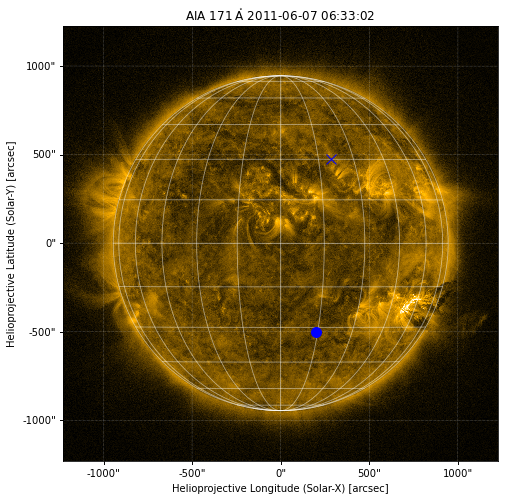

In [81]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, clip_interval=[0.5, 99.99]*u.percent)

aia_map.draw_grid(axes=ax)

ax.plot_coord(coord1, marker='o', ms=10, color='b')
ax.plot_coord(coord2, marker='x', ms=10, color='b')


There's lots of functionality within the coordinates stack and utilities to do some nice things with these plots. One such example is to draw a great arc on the map between two points using [`GreatArc`](https://docs.sunpy.org/en/stable/api/sunpy.coordinates.utils.GreatArc.html?highlight=great%20arc)!

In [82]:
from sunpy.coordinates.utils import GreatArc
great_arc = GreatArc(coord1, coord2)


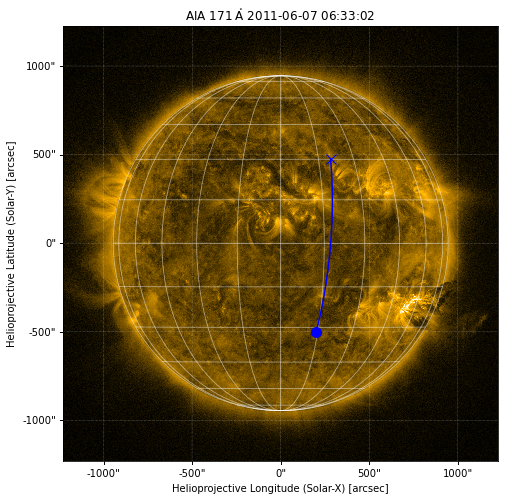

In [83]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, clip_interval=[0.5, 99.99]*u.percent)

aia_map.draw_grid(axes=ax)

ax.plot_coord(coord1, marker='o', ms=10, color='b')
ax.plot_coord(coord2, marker='x', ms=10, color='b')
ax.plot_coord(great_arc.coordinates(), color='b')

## Crop a map - choose a region of interest

We can create a subamp from a map using the [`map.submap()`](https://docs.sunpy.org/en/stable/api/sunpy.map.GenericMap.html#sunpy.map.GenericMap.submap) function.

To create a submap you pass a bottom left coordinate for the defined rectagngle, and then either pass a top right coordinate, or instead a width and a height. Lets define a bottom left and top right

In [84]:
bottom_left = SkyCoord(550*u.arcsec, -700*u.arcsec, frame=aia_map.coordinate_frame)
top_right = SkyCoord(1200*u.arcsec, 10*u.arcsec, frame=aia_map.coordinate_frame)

In [85]:
submap = aia_map.submap(bottom_left, top_right=top_right)

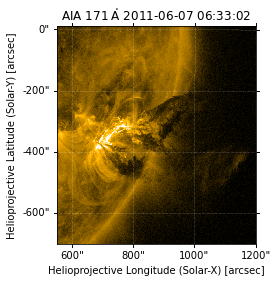

In [86]:
submap.plot(clip_interval=(3, 99.9)*u.percent)

Or instead you can pass width or height

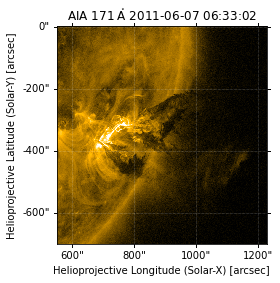

In [87]:
submap2 = aia_map.submap(bottom_left, width=700*u.arcsec, height=700*u.arcsec)
submap2.plot(clip_interval=(3, 99.9)*u.percent)

### Plot together

We can use the `map.draw_quadrangle` function to plot a rectangle on the original map of the shape that created the submap

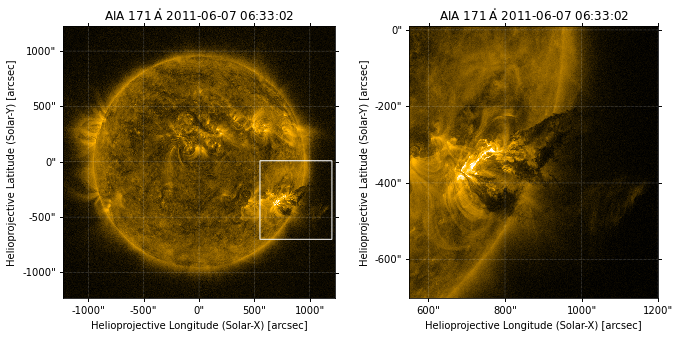

In [88]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1,2,1,projection=aia_map)
aia_map.plot(axes=ax1, clip_interval=(0.1, 99.99)*u.percent)
# draw rectangle on the map
aia_map.draw_quadrangle(bottom_left, top_right=top_right, 
                        axes=ax1)

ax2 = fig.add_subplot(1,2,2,projection=submap)
submap.plot(clip_interval=(0.5, 99.95)*u.percent)

## Save a Map

You can save a map to a fits file by using the .`save()` functionality on the map. 

In [93]:
# save a file

submap.save("my_submap.fits")

In [94]:
# read it back in
my_submap = sunpy.map.Map("my_submap.fits")

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2011-06-07 06:33:02
Exposure Time,0.234256 s
Dimension,[1085. 1185.] pix
Coordinate System,helioprojective
Scale,[0.599489 0.599489] arcsec / pix
Reference Pixel,[-917.540039 1168.030029] pix

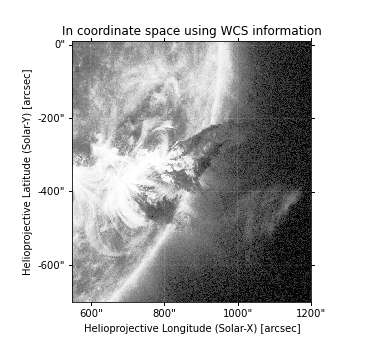
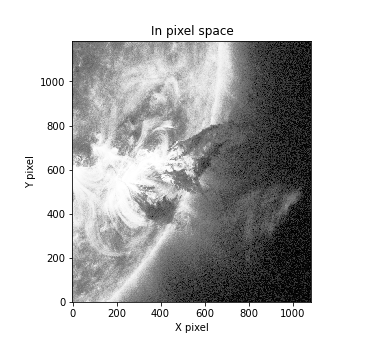
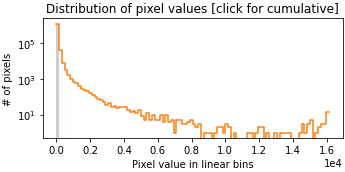
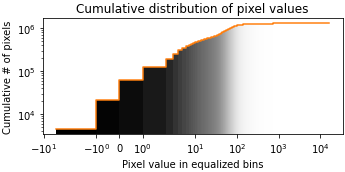

In [95]:
my_submap

# 6. Exercise!

Now you have seen a snap shot of how to query for and download data, and how to read in this data and inspect/plot, lets now try use these new skills to do your own analysis!


## Do analysis for the large September flare in 2017

In Sept 2017 a large active region was present on the Sun and hosted two of the largest flares of the past solar cycle. One of the most well observed flares, and perfectly orientated was the X8.2 solar flare that occured on September 10 2017. The flare began at approximately 15:30 UT and lasted for several hours. 

The exercise for you now is to analyse data from this event. 

The steps that we want you to do:

1. Find the GOES XRS data - choose the GOES 15 Satellite data. Plot this as a timeseries and truncate it to the time of the flare.
2. Inspect that SDO/AIA data at the time for the 171 angstrom and 131 angstrom channels. AIA data has a cadence of 12 seconds, but only search for data over the time period of 15:30 to 20:00 at 15 minute intervals (i.e. use the a.Sample atts when searching).
3. Read in these Maps and inspect them individually - what do you see? Can you see where the flare is? 
4. Crop the region of interest and make a submap
5. If you finish in time - think of some interesting things you can do with the data. Have a look at the [sunpy example gallery](https://docs.sunpy.org/en/stable/generated/gallery/index.html#)




In [96]:
tstart = '2017-09-10 15:00'
tend = '2017-09-10 20:00'

In [97]:
result_xrs = Fido.search(a.Time(tstart, tend), 
                         a.Instrument("XRS"), a.goes.SatelliteNumber(15))

In [98]:
result_xrs

Start Time,End Time,Instrument,SatelliteNumber,Physobs,Source,Provider
object,object,str3,int64,str10,str4,str4
2017-09-10 00:00:00.000,2017-09-10 23:59:59.999,XRS,15,irradiance,GOES,NOAA


In [99]:
file_xrs = Fido.fetch(result_xrs, path="/Users/laurahayes/SWW_tutorial/")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [100]:
xrs = sunpy.timeseries.TimeSeries(file_xrs)

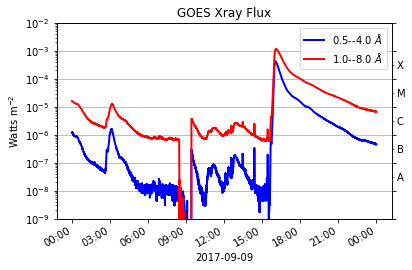

In [101]:
xrs.peek()

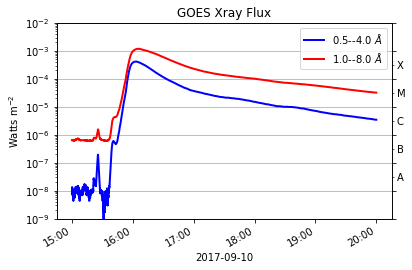

In [102]:
xrs_flare = xrs.truncate(tstart, tend)
xrs_flare.peek()

Lets now look for AIA data

In [103]:
result_aia = Fido.search(a.Time(tstart, tend), 
                     a.Instrument("AIA"), 
                     a.Wavelength(171*u.angstrom) | a.Wavelength(131*u.angstrom), 
                     a.Sample(15*u.min))

/Users/laurahayes/opt/miniconda3/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


In [104]:
files_aia = Fido.fetch(result_aia, path="/Users/laurahayes/SWW_tutorial/")

Files Downloaded:   0%|          | 0/20 [00:00<?, ?file/s]

As well as individual files, sunpy.map.Map can also take a list of files and then create a list of maps:

In [105]:
aia_maps_131 = sunpy.map.Map("/Users/laurahayes/SWW_tutorial/*131a*fits")

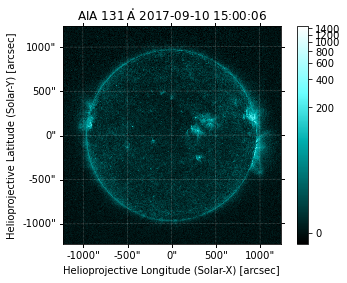

In [106]:
aia_maps_131[0].plot(clip_interval=(0.1, 100)*u.percent)
plt.colorbar()

 # More fun coordinates things

## Positions of solar system bodies

`sunpy.coordinates provides` functions to obtain the coordinates of solar-system bodies. 

The function [`get_body_heliographic_stonyhurst`](https://docs.sunpy.org/en/stable/api/sunpy.coordinates.get_body_heliographic_stonyhurst.html?highlight=get_body_heliographic_stonyhurst) which will return the location of the solar-system body in the HeliographicStonyhurst frame.

For other solar-system bodies (e.g., major man-made spacecraft or comets), you can use [`get_horizons_coord()`](https://docs.sunpy.org/en/stable/api/sunpy.coordinates.get_horizons_coord.html?highlight=get_horizons_coord()#sunpy.coordinates.get_horizons_coord), which queries JPL HORIZONS:

In [107]:
earth_pos = get_body_heliographic_stonyhurst("earth", "2021-07-11")

In [108]:
earth_pos

<HeliographicStonyhurst Coordinate (obstime=2021-07-11T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (0., 3.93116994, 1.01665388)>

In [109]:
mars_pos = get_body_heliographic_stonyhurst("mars", "2021-07-11")
mars_pos

<HeliographicStonyhurst Coordinate (obstime=2021-07-11T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (-133.1605246, -5.35312526, 1.6659266)>

For other solar-system bodies (e.g., major man-made spacecraft or comets), you can use get_horizons_coord(), which queries JPL HORIZONS:

In [110]:
solo_coord = get_horizons_coord('Solar Orbiter', "2021-06-30")

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [111]:
solo_coord

<SkyCoord (HeliographicStonyhurst: obstime=2021-06-30T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (-100.20317075, -1.67873, 0.91390082)>

# Now lets have a look at a recent Parker Solar Probe (PSP) perihelion 

In [112]:
obstime_seq = parse_time('2021-04-22 04:30') + np.arange(-14, 14)*u.day

In [113]:
psp_coord_seq = get_horizons_coord('Parker Solar Probe', obstime_seq)
solo_coord_seq = get_horizons_coord('solo', obstime_seq)

INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [114]:
psp_coord_seq

<SkyCoord (HeliographicStonyhurst: obstime=['2021-04-08T04:30:00.000' '2021-04-09T04:30:00.000'
 '2021-04-10T04:30:00.000' '2021-04-11T04:30:00.000'
 '2021-04-12T04:30:00.000' '2021-04-13T04:30:00.000'
 '2021-04-14T04:30:00.000' '2021-04-15T04:30:00.000'
 '2021-04-16T04:30:00.000' '2021-04-17T04:30:00.000'
 '2021-04-18T04:30:00.000' '2021-04-19T04:30:00.000'
 '2021-04-20T04:30:00.000' '2021-04-21T04:30:00.000'
 '2021-04-22T04:30:00.000' '2021-04-23T04:30:00.000'
 '2021-04-24T04:30:00.000' '2021-04-25T04:30:00.000'
 '2021-04-26T04:30:00.000' '2021-04-27T04:30:00.000'
 '2021-04-28T04:30:00.000' '2021-04-29T04:30:00.000'
 '2021-04-30T04:30:00.000' '2021-05-01T04:30:00.000'
 '2021-05-02T04:30:00.000' '2021-05-03T04:30:00.000'
 '2021-05-04T04:30:00.000' '2021-05-05T04:30:00.000'], rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    [( 145.7104366 ,  3.85744241e+00, 0.58774304),
     ( 145.80414313,  3.85778829e+00, 0.57326641),
     ( 145.95595664,  3.85667567e+00, 0.55810224),
    

In [115]:
earth_seq = SkyCoord(get_body_heliographic_stonyhurst("earth", obstime_seq))
sun_seq = SkyCoord(get_body_heliographic_stonyhurst("sun", obstime_seq))

Text(0.5, 1.0, 'Positions in HCI frame')

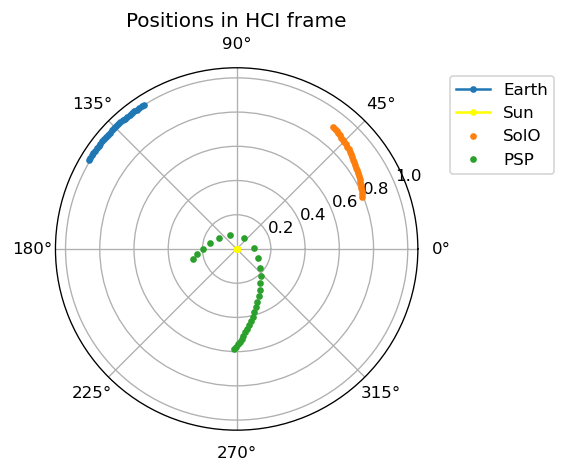

In [116]:
plt.figure(dpi=120)

ax = plt.subplot(projection='polar')

ax.plot(earth_seq.heliocentricinertial.lon.to(u.rad), earth_seq.heliocentricinertial.distance, marker='.', label="Earth")
ax.plot(sun_seq.heliocentricinertial.lon.to(u.rad), sun_seq.heliocentricinertial.distance, marker='.', label="Sun", color="yellow")





ax.plot(solo_coord_seq.heliocentricinertial.lon.to(u.rad), solo_coord_seq.heliocentricinertial.distance,
        '.',   label='SolO')

ax.plot(psp_coord_seq.heliocentricinertial.lon.to(u.rad), psp_coord_seq.heliocentricinertial.distance,
        '.',   label='PSP')

ax.legend(bbox_to_anchor=(1.4,1), loc='upper right')
ax.set_title("Positions in HCI frame")

Reprojecting